## imports

In [1]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import bootstrap

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import TargetEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.model_selection import cross_validate
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import GradientBoostingRegressor

## helpful functions

In [2]:
def get_missingness(dframe):
    missing_columns = []
    for column in dframe.columns:
        na_perc=np.sum(dframe[column].isna())/dframe.shape[0]
        print(column, na_perc)
        if na_perc>0.2:
            print(f"\n{column} missingness too high ({round(na_perc,3)*100}%)\n")
            missing_columns.append(column)
    return missing_columns

def group_features(dframe,target):
    non_ml_attr=[]
    nominal_attr = []
    numerical_attr = []

    print("Column\t\tuniqueness\tdatatype")


    for column in dframe.loc[:, dframe.columns != target].columns: #get all columns except for the target column
        n_unique = len(dframe[column].unique())
        p_unique = round(n_unique/dframe.shape[0]*100,3)
        c_type = dframe.dtypes[column]
        print(f"{column}\t\t{p_unique}%\t\t{c_type}")

        if dframe[column].dtype == pd.api.types.pandas_dtype('int64') and p_unique > 99:
            print(f"\nPotential ID, inspect {column}\n")
            non_ml_attr.append(column)
        
        elif dframe[column].dtype == pd.api.types.pandas_dtype(object):
            nominal_attr.append(column)
        
        else: #watch out for integers that could be categories here
            numerical_attr.append(column)

    print(f"\n\nNon ML Attribute list:\t\t{non_ml_attr}")
    print(f"Numerical Attributes:\t\t{numerical_attr}")
    print(f"Nominal Attributes:\t\t{nominal_attr}")

    return non_ml_attr, numerical_attr, nominal_attr

def get_x_y(dframe,target):
    x = dframe.loc[:, dframe.columns != target]
    y = dframe[target].values.ravel()

    return x,y


def false_discovery_test(model,train,val,target,n_bootstraps=20):
    
    bootstrapped_unscrambled = []
    bootstrapped_scrambled = []
    
    for i in range(n_bootstraps):
        #bootstrap samples from the train set
        boot_train = resample(train, replace=True, random_state=i) 
        boot_train_x, boot_train_y = get_x_y(boot_train,target)

        boot_val = resample(val, replace=True, random_state=i) 
        boot_val_x, boot_val_y = get_x_y(boot_val, target)

        #fit the model to the unscrambled bootstrapped sample
        model.fit(boot_train_x,boot_train_y)
        #predict the validation datapoints using the unscrambled bootstrap sample
        boot_val_pred_y = model.predict(boot_val_x)
        #add the unscrambled validation score (RMSE) to the unscrambled list
        bootstrapped_unscrambled.append(mean_squared_error(boot_val_y, boot_val_pred_y, squared=False))

        #scramble the boot_y_df
        scrambled_boot_train_y = shuffle(boot_train_y, random_state=i)#.values.ravel(), random_state = i)
        #fit the model to the scrambled data
        model.fit(boot_train_x,scrambled_boot_train_y)
        #predict using the scrambled model
        boot_val_pred_y_scrambled = model.predict(boot_val_x)
        #add the scrambled validation score to the scrambled list
        bootstrapped_scrambled.append(mean_squared_error(boot_val_y,boot_val_pred_y_scrambled, squared=False))
    

    unscrambled = bootstrap((bootstrapped_unscrambled,),np.mean,confidence_level=0.95, random_state=42)
    scrambled = bootstrap((bootstrapped_scrambled,),np.mean,confidence_level=0.95, random_state=42)

    fig, ax = plt.subplots()
    ax.hist(unscrambled.bootstrap_distribution, bins=25, label='Unscrambled', alpha = 0.5)
    ax.hist(scrambled.bootstrap_distribution, bins=25, label='Scrambled', alpha = 0.5)
    ax.set_title('Bootstrap Distribution')
    ax.set_xlabel('Average Precision Score')
    ax.set_ylabel('frequency')
    fig.legend(loc='upper right')
    plt.show()
    
    print("Unscrambled 95% confidence interval: ",unscrambled.confidence_interval)
    print("Scrambled 95% confidence interval: ",scrambled.confidence_interval)

def boot_val(model,val,target, n_bootstraps=20):
    df_name = test(val)
    print(f'\n{df_name} Statistic Score: Fractional RMSE')
    t_score = []
    for i in range(n_bootstraps):
        boot_val = resample(val, replace=True, random_state=i)
        
        boot_x, boot_y = get_x_y(boot_val, target)

        boot_pred = model.predict(boot_x)

        mse = mean_squared_error(boot_y,boot_pred)
        rmse = np.sqrt(mse)
        frac_rmse = rmse/np.mean(boot_y)


        t_score.append(frac_rmse)
    
    bci = bootstrap((t_score,), np.mean, confidence_level=0.95, random_state=42)
    print('\tBootstrapped',bci.confidence_interval)
    return bci

#stolen from here: https://stackoverflow.com/questions/41684553/print-dataframe-name
def test(data):
    name =[x for x in globals() if globals()[x] is data][0]
    return name



## parameters

In [3]:
target = 'y'

testing = False
frac = 0.1

## script run time - start timer

In [4]:
start = time.time()

## load the data

In [5]:
data = pd.read_csv('data_set_2.csv')
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   attr_0   50000 non-null  int64  
 1   attr_1   50000 non-null  float64
 2   attr_2   49503 non-null  float64
 3   attr_3   48532 non-null  object 
 4   attr_4   44770 non-null  float64
 5   attr_5   47569 non-null  float64
 6   attr_6   50000 non-null  object 
 7   attr_7   50000 non-null  float64
 8   attr_8   48036 non-null  float64
 9   attr_9   49010 non-null  float64
 10  attr_10  33529 non-null  float64
 11  attr_11  45697 non-null  float64
 12  y        49504 non-null  float64
dtypes: float64(10), int64(1), object(2)
memory usage: 5.0+ MB


## drop observations with nans in the target attribute

In [6]:
data2 = data[data[target].notna()] 
print(data2.shape)

(49504, 13)


## train/test split

## train/validation split

In [7]:
train_df, test_df = train_test_split(data2, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=42)

print(f"Train size:\t\t{train_df.shape}")
print(f"Validation Size:\t{val_df.shape}")
print(f"Test Size:\t\t{test_df.shape}")

Train size:		(29702, 13)
Validation Size:	(9901, 13)
Test Size:		(9901, 13)


## configure machine learning attributes

### check for high missingness

In [8]:
missing_columns = get_missingness(train_df)

attr_0 0.0
attr_1 0.0
attr_2 0.009898323345229278
attr_3 0.029088950239041143
attr_4 0.10450474715507373
attr_5 0.04875092586357821
attr_6 0.0
attr_7 0.0
attr_8 0.03976163221331897
attr_9 0.019830314456938926
attr_10 0.3288330752137903

attr_10 missingness too high (32.9%)

attr_11 0.08629048548919264
y 0.0


In [9]:
print(f"Dropping the following columns based on missingness: {missing_columns}")

val_df = val_df.drop(missing_columns, axis=1)
test_df = test_df.drop(missing_columns, axis=1)
train_df = train_df.drop(missing_columns, axis=1)

Dropping the following columns based on missingness: ['attr_10']


### identify non machine learning attributes

### get attributes by dtypes

### machine learning attribute configuration

In [10]:
non_ml_attr, numerical_attr, nominal_attr = group_features(train_df,target)

Column		uniqueness	datatype
attr_0		100.0%		int64

Potential ID, inspect attr_0

attr_1		100.0%		float64
attr_2		99.014%		float64
attr_3		0.01%		object
attr_4		89.553%		float64
attr_5		95.128%		float64
attr_6		0.013%		object
attr_7		100.0%		float64
attr_8		96.027%		float64
attr_9		98.02%		float64
attr_11		91.374%		float64


Non ML Attribute list:		['attr_0']
Numerical Attributes:		['attr_1', 'attr_2', 'attr_4', 'attr_5', 'attr_7', 'attr_8', 'attr_9', 'attr_11']
Nominal Attributes:		['attr_3', 'attr_6']


In [11]:
train_df.head(20)

,attr_0,attr_1,attr_2,attr_3,attr_4,attr_5,attr_6,attr_7,attr_8,attr_9,attr_11,y
32836,39321,1.845514,-0.253431,cat_1,NaN,1.016623,cat_1,1.234556,0.534116,NaN,NaN,985.887594
38548,14920,-0.731265,1.755117,cat_1,-0.364638,-0.066505,cat_1,-0.210752,NaN,-1.370929,0.382790,967.537973
9569,23857,0.823217,-0.047744,cat_0,1.179382,-0.182442,cat_1,0.387829,0.852835,-1.340005,-0.907098,924.285298
36105,38690,-2.270654,1.700942,cat_1,0.101755,-1.180158,cat_2,-0.965857,NaN,-1.455915,1.034512,999.690555
48325,41187,0.811554,-0.527235,cat_0,1.719100,0.275274,cat_1,-1.054896,0.488147,1.633537,-1.168040,875.759464
819,43553,-1.960137,-1.610373,cat_0,-2.021372,-0.607378,cat_2,-0.045290,0.905071,1.124512,0.851420,1009.552724
46772,5245,0.039694,0.178652,cat_1,-0.447190,0.189023,cat_2,0.128595,-0.842098,-0.795950,-0.374282,941.362091
27238,4931,1.674397,1.552666,cat_1,-0.773444,-0.216507,cat_1,-0.790555,0.080173,-0.892962,-0.495649,1116.610603
37546,22712,-1.541800,0.175527,cat_0,-0.748983,-0.357681,cat_1,-0.567193,-1.046644,-0.417300,1.757271,918.596564
35141,45969,0.620720,-0.030889,cat_0,-1.316048,0.261318,cat_2,-1.535776,-0.599107,-0.367246,-0.675919,1081.307388


### identify attributes that were candidates for machine learning but you have chosen to eliminate from machine learning - feature selection

In [12]:
print(f"Dropping the following columns based on uniqueness+data type: {non_ml_attr}")

val_df = val_df.drop(non_ml_attr, axis=1)
test_df = test_df.drop(non_ml_attr, axis=1)
train_df = train_df.drop(non_ml_attr, axis=1)

dropped_columns = non_ml_attr + missing_columns

Dropping the following columns based on uniqueness+data type: ['attr_0']


In [13]:
assert len(data.columns) == len(nominal_attr+numerical_attr+dropped_columns)+1 #+1 for target

assert np.all(train_df.columns == test_df.columns)
assert np.all(train_df.columns == val_df.columns)

In [14]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29702 entries, 32836 to 10728
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   attr_1   29702 non-null  float64
 1   attr_2   29408 non-null  float64
 2   attr_3   28838 non-null  object 
 3   attr_4   26598 non-null  float64
 4   attr_5   28254 non-null  float64
 5   attr_6   29702 non-null  object 
 6   attr_7   29702 non-null  float64
 7   attr_8   28521 non-null  float64
 8   attr_9   29113 non-null  float64
 9   attr_11  27139 non-null  float64
 10  y        29702 non-null  float64
dtypes: float64(9), object(2)
memory usage: 2.7+ MB


## build the preprocessing pipeline

In [15]:
numerical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy='median')), 
           ("scaler", StandardScaler())]
)

nominal_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="most_frequent")), 
           ('target_encoder', TargetEncoder(target_type='continuous', random_state=42)),
           ("scaler", StandardScaler())
          ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', numerical_transformer, numerical_attr),
        ('nominal', nominal_transformer, nominal_attr)
    ]
)

## define default estimators

In [16]:
sgd = SGDRegressor(random_state=42)
rf = RandomForestRegressor(random_state=42)
gb = GradientBoostingRegressor(random_state=42)
en = ElasticNet(random_state=42)

pipe = Pipeline([('preprocessor', preprocessor),('model',sgd)])

sgd_params = {}
sgd_params['model'] = [sgd]
sgd_params['model__random_state'] = [42]

rf_params = {}
rf_params['model'] = [rf]
rf_params['model__random_state'] = [42]


gb_params = {}
gb_params['model'] = [gb]
gb_params['model__random_state'] = [42]

en_params = {}
en_params['model'] = [en]
en_params['model__random_state'] = [42]


params = [sgd_params, rf_params, gb_params, en_params]

## build the composite estimator

In [17]:
default_grid = GridSearchCV(pipe,params, scoring='neg_root_mean_squared_error',return_train_score=True, verbose = 4)

## default model survey

### train the default model

In [18]:
#If we're trying to do fast development we will edit the train and val set to be smaller
if testing:
    print('Train shape before resample: ',train_df.shape)
    print('Validation shape before resample: ',val_df.shape)

    train_df = resample(train_df, replace=False, n_samples = (round(train_df.shape[0]*frac)), random_state=42)
    val_df = resample(val_df, replace=False, n_samples = (round(val_df.shape[0]*frac)), random_state=42)

    print('Train shape after resample: ',train_df.shape)
    print('Validaiton shape after resample: ',val_df.shape)

In [19]:
train_x, train_y = get_x_y(train_df,target)

default_grid.fit(train_x,train_y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[CV 1/5] END model=SGDRegressor(random_state=42), model__random_state=42;, score=(train=-101.892, test=-101.674) total time=   0.1s
[CV 2/5] END model=SGDRegressor(random_state=42), model__random_state=42;, score=(train=-101.866, test=-101.920) total time=   0.0s
[CV 3/5] END model=SGDRegressor(random_state=42), model__random_state=42;, score=(train=-101.552, test=-102.844) total time=   0.1s
[CV 4/5] END model=SGDRegressor(random_state=42), model__random_state=42;, score=(train=-102.262, test=-99.862) total time=   0.0s
[CV 5/5] END model=SGDRegressor(random_state=42), model__random_state=42;, score=(train=-101.584, test=-102.893) total time=   0.0s
[CV 1/5] END model=RandomForestRegressor(random_state=42), model__random_state=42;, score=(train=-47.883, test=-105.892) total time= 1.0min
[CV 2/5] END model=RandomForestRegressor(random_state=42), model__random_state=42;, score=(train=-47.959, test=-106.872) total time= 1.0min
[CV 3/5] END model=RandomForestRegressor(random_state=42), mo

GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['attr_1',
                                                                          'attr_2',
                                                                          'attr_4',
                                                                          'attr_5',
                                                                          'attr_7',
                                                                          'attr_8',
                                                                          'attr_9',
                                                                          'attr_11']),
                                                                        ('nominal',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ta...
             param_grid=[{'model': [SGDRegressor(random_state=42)],
                          'model__random_state': [42]},
                         {'model': [RandomForestRegressor(random_state=42)],
                          'model__random_state': [42]},
                         {'model': [GradientBoostingRegressor(random_state=42)],
                          'model__random_state': [42]},
                         {'model': [ElasticNet(random_state=42)],
                          'model__random_state': [42]}],
             return_train_score=True, scoring='neg_root_mean_squared_error',
             verbose=4)

### evaluate the default model on the validation set by bootstrapping without refit - get the low and high limits

In [20]:
compare_default_df = pd.DataFrame(default_grid.cv_results_)
compare_default_df['frac_rmse_test_score'] = (-compare_default_df['mean_test_score'])/train_y.mean()

compare_default_df[['param_model','mean_train_score','mean_test_score','std_train_score','std_test_score','frac_rmse_test_score','rank_test_score']]

,param_model,mean_train_score,mean_test_score,std_train_score,std_test_score,frac_rmse_test_score,rank_test_score
0,SGDRegressor(random_state=42),-101.831204,-101.838626,0.256678,1.101171,0.101161,1
1,RandomForestRegressor(random_state=42),-47.912169,-106.963490,0.269512,1.230455,0.106252,3
2,GradientBoostingRegressor(random_state=42),-100.304482,-102.963783,0.275121,1.190282,0.102279,2
3,ElasticNet(random_state=42),-116.415441,-116.450355,0.222418,0.957643,0.115676,4


In [21]:
val_x, val_y = get_x_y(val_df,target)

In [22]:
print('Default Train Fractional RMSE: ',round(mean_squared_error(train_y,default_grid.best_estimator_.predict(train_x), squared=False)/train_y.mean(),4))

print('Default Validation Fractional RMSE: ',round(mean_squared_error(val_y,default_grid.best_estimator_.predict(val_x), squared=False)/val_y.mean(),4))

Default Train Fractional RMSE:  0.1012
Default Validation Fractional RMSE:  0.1017


In [23]:
train_bci = boot_val(default_grid.best_estimator_,train_df,target)
val_bci = boot_val(default_grid.best_estimator_,val_df,target)



train_df Statistic Score: Fractional RMSE
	Bootstrapped ConfidenceInterval(low=0.10086567358932835, high=0.10128648921823004)

val_df Statistic Score: Fractional RMSE
	Bootstrapped ConfidenceInterval(low=0.1013567767979022, high=0.10190734877791537)


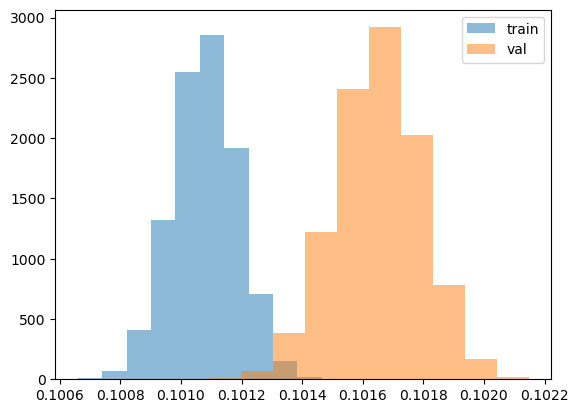

In [24]:
plt.hist(train_bci.bootstrap_distribution, alpha=0.5,label='train')
plt.hist(val_bci.bootstrap_distribution, alpha=0.5, label='val')
plt.legend()
plt.show()

## tune two estimator hyperparameters - you will not be tuning the preprocessing stage in this round of experimentation

### set up the hyperparameter grid

### Set a grid for each model evaluated, but only gridsearch over the model that performed the best in the default gridsearch

In [25]:
rf_params = {}
rf_params['model'] = [rf]
rf_params['model__n_estimators'] = [10,100,500]
rf_params['model__max_depth'] = [None]
rf_params['model__max_features'] = ['sqrt',2,None]

sgd_params = {}
sgd_params['model'] = [sgd]
#sgd_params['model__learning_rate'] = ['constant','optimal','invscaling']
sgd_params['model__alpha'] = list(np.geomspace(0.0001,1,4)) 
sgd_params['model__penalty'] = ['l2','l1','elasticnet']

gb_params = {}
gb_params['model'] = [gb]
gb_params['model__n_estimators'] = [50,100,500]
gb_params['model__criterion'] = ['friedman_mse','squared_error']

en_params = {}
en_params['model'] = [en]
en_params['model__alpha'] = list(np.linspace(0.01,10,4))
en_params['model__l1_ratio'] = list(list(np.linspace(0.0,1,4)))

models = [rf_params, sgd_params, gb_params, en_params]
for model in models:
    if type(model['model'][0]).__name__ == type(default_grid.best_estimator_.named_steps['model']).__name__:
        params = [model]
        print(params,'\n\n')
        break

tuned_grid = GridSearchCV(pipe,params, scoring='neg_root_mean_squared_error',return_train_score=True, verbose = 4)
tuned_grid.fit(train_x,train_y)

[{'model': [SGDRegressor(random_state=42)], 'model__alpha': [0.0001, 0.002154434690031882, 0.046415888336127774, 1.0], 'model__penalty': ['l2', 'l1', 'elasticnet']}] 


Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END model=SGDRegressor(random_state=42), model__alpha=0.0001, model__penalty=l2;, score=(train=-101.892, test=-101.674) total time=   0.0s
[CV 2/5] END model=SGDRegressor(random_state=42), model__alpha=0.0001, model__penalty=l2;, score=(train=-101.866, test=-101.920) total time=   0.0s
[CV 3/5] END model=SGDRegressor(random_state=42), model__alpha=0.0001, model__penalty=l2;, score=(train=-101.552, test=-102.844) total time=   0.1s
[CV 4/5] END model=SGDRegressor(random_state=42), model__alpha=0.0001, model__penalty=l2;, score=(train=-102.262, test=-99.862) total time=   0.0s
[CV 5/5] END model=SGDRegressor(random_state=42), model__alpha=0.0001, model__penalty=l2;, score=(train=-101.584, test=-102.893) total time=   0.0s
[CV 1/5] END model=SGDRegressor

GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['attr_1',
                                                                          'attr_2',
                                                                          'attr_4',
                                                                          'attr_5',
                                                                          'attr_7',
                                                                          'attr_8',
                                                                          'attr_9',
                                                                          'attr_11']),
                                                                        ('nominal',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ta...
                                        SGDRegressor(alpha=0.002154434690031882,
                                                     penalty='elasticnet',
                                                     random_state=42))]),
             param_grid=[{'model': [SGDRegressor(alpha=0.002154434690031882,
                                                 penalty='elasticnet',
                                                 random_state=42)],
                          'model__alpha': [0.0001, 0.002154434690031882,
                                           0.046415888336127774, 1.0],
                          'model__penalty': ['l2', 'l1', 'elasticnet']}],
             return_train_score=True, scoring='neg_root_mean_squared_error',
             verbose=4)

In [26]:
compare_tuned_df = pd.DataFrame(tuned_grid.cv_results_)
compare_tuned_df['frac_rmse_test_score'] = (-compare_tuned_df['mean_test_score'])/train_y.mean()

compare_tuned_df[['param_model','mean_train_score','mean_test_score','std_train_score','std_test_score','frac_rmse_test_score','rank_test_score']].sort_values('rank_test_score')

,param_model,mean_train_score,mean_test_score,std_train_score,std_test_score,frac_rmse_test_score,rank_test_score
5,"SGDRegressor(alpha=0.002154434690031882, penal...",-101.831159,-101.827273,0.256002,1.089776,0.101150,1
3,"SGDRegressor(alpha=0.002154434690031882, penal...",-101.833349,-101.828185,0.255381,1.090670,0.101151,2
7,"SGDRegressor(alpha=0.002154434690031882, penal...",-101.793480,-101.829475,0.256332,1.112054,0.101152,3
1,"SGDRegressor(alpha=0.002154434690031882, penal...",-101.830462,-101.838045,0.257002,1.100584,0.101161,4
2,"SGDRegressor(alpha=0.002154434690031882, penal...",-101.831092,-101.838537,0.256728,1.101082,0.101161,5
0,"SGDRegressor(alpha=0.002154434690031882, penal...",-101.831204,-101.838626,0.256678,1.101171,0.101161,6
4,"SGDRegressor(alpha=0.002154434690031882, penal...",-101.818154,-101.853633,0.248028,1.126773,0.101176,7
10,"SGDRegressor(alpha=0.002154434690031882, penal...",-101.845596,-101.869643,0.246929,1.146956,0.101192,8
8,"SGDRegressor(alpha=0.002154434690031882, penal...",-101.945564,-101.992523,0.284471,1.064423,0.101314,9
6,"SGDRegressor(alpha=0.002154434690031882, penal...",-102.111713,-102.129540,0.281489,1.070615,0.101450,10


### examine the best hyperparameters from the GridSearchCV - make sure your hyperparameter grid was well designed to give your model a chance to explore the hyperparameter space

In [27]:
tuned_grid.best_params_

{'model': SGDRegressor(alpha=0.002154434690031882, penalty='elasticnet', random_state=42),
 'model__alpha': 0.002154434690031882,
 'model__penalty': 'elasticnet'}

### evaluate the tuned model on the validation set by bootstrapping without refit - get the low and high limits

In [28]:
best_model = tuned_grid.best_estimator_

In [29]:
tuned_val_bci = boot_val(best_model,val_df,target)

tuned_train_bci = boot_val(best_model,train_df,target)


val_df Statistic Score: Fractional RMSE
	Bootstrapped ConfidenceInterval(low=0.10134953690199092, high=0.10189960850413939)

train_df Statistic Score: Fractional RMSE
	Bootstrapped ConfidenceInterval(low=0.10086158330840164, high=0.10128184552581614)


## evaluate the tuned model on the test set by bootstrapping without refit - get the low and high limits

In [30]:
tuned_test_bci = boot_val(best_model,test_df,target)


test_df Statistic Score: Fractional RMSE
	Bootstrapped ConfidenceInterval(low=0.10111640096124144, high=0.10174691242379377)


In [31]:
tuned_test = tuned_test_bci
print(f"Average Precision Score on 20 Bootstrapped Test Sets: {tuned_test.bootstrap_distribution.mean():.4f} +/- {tuned_test.standard_error:0.4f}")
print(f"95% Confidence interval: {tuned_test.confidence_interval[0]:0.4f} to {tuned_test.confidence_interval[1]:0.4f}")

Average Precision Score on 20 Bootstrapped Test Sets: 0.1014 +/- 0.0002
95% Confidence interval: 0.1011 to 0.1017


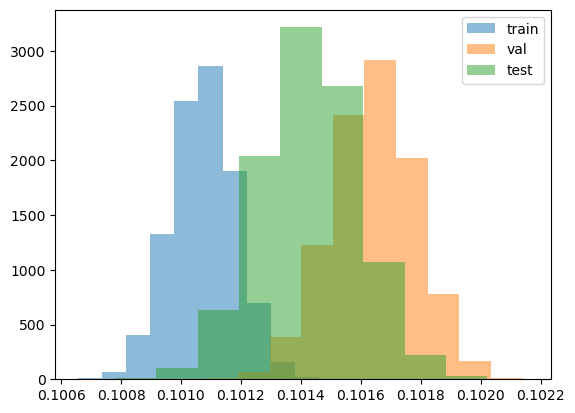

In [32]:
plt.hist(tuned_train_bci.bootstrap_distribution, alpha=0.5,label='train')
plt.hist(tuned_val_bci.bootstrap_distribution, alpha=0.5, label='val')
plt.hist(tuned_test_bci.bootstrap_distribution, alpha=0.5, label='test')

plt.legend()
plt.show()

In [33]:
test_x, test_y = get_x_y(test_df, target)

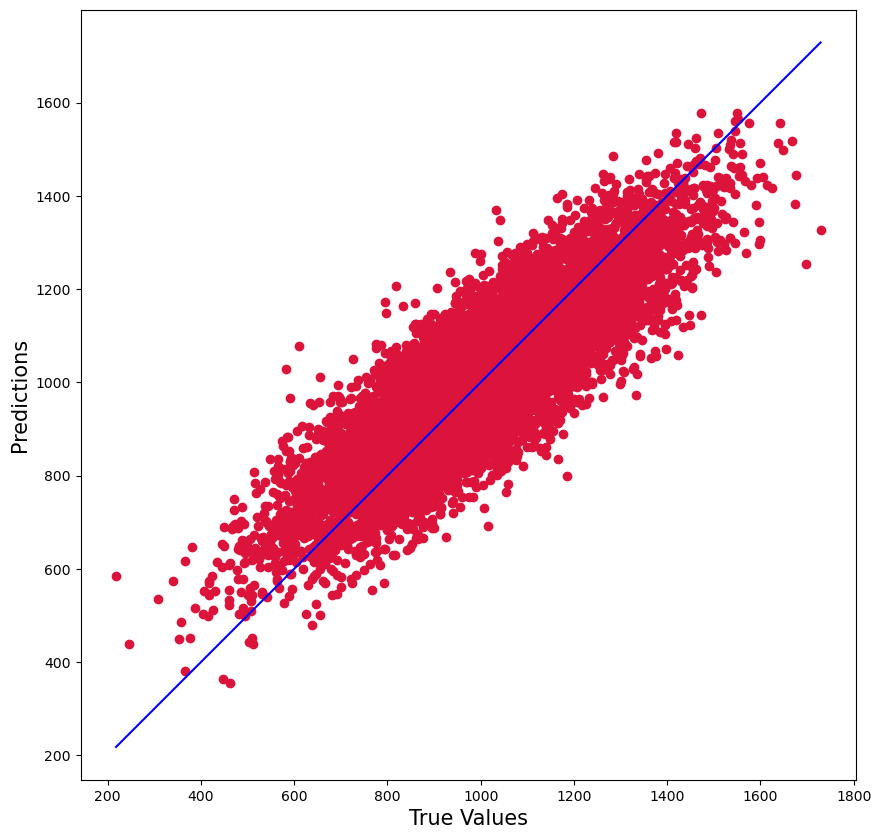

In [34]:
pred_test_y = best_model.predict(test_x)
plt.figure(figsize=(10,10))
plt.scatter(test_y, pred_test_y, c='crimson')

p1 = max(max(pred_test_y), max(test_y))
p2 = min(min(pred_test_y), min(test_y))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

## check out script run time

In [35]:
end = time.time()
print(f'script run time: {(end - start)/60} minutes')

script run time: 6.859505653381348 minutes
